In [1]:
import json
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering

#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
import geopandas as gpd
from geopandas.tools import sjoin


In [2]:
cities = {}
categories = {}
with open('yelp_dataset/business.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        c = d['city']
        ca = d['categories']
        if ca:
            for cat in ca.replace(' ','').split(','):
                if cat in categories:
                    categories[cat]+=1
                else:
                    categories[cat]=1
        if c in cities:
            cities[c]+=1
        else:
            cities[c]=1

In [3]:
list(islice({k: v for k, v in sorted(cities.items(), key=lambda item: -item[1])}.items(),4))

[('Las Vegas', 29370),
 ('Toronto', 18906),
 ('Phoenix', 18766),
 ('Charlotte', 9509)]

In [4]:
list(islice({k: v for k, v in sorted(categories.items(), key=lambda item: -item[1])}.items(),10))

[('Restaurants', 59371),
 ('Shopping', 31878),
 ('Food', 29989),
 ('HomeServices', 19729),
 ('Beauty&Spas', 19370),
 ('Health&Medical', 17171),
 ('LocalServices', 13932),
 ('Automotive', 13203),
 ('Nightlife', 13095),
 ('Bars', 11341)]

In [5]:
useful_cats = [a[0] for a in list(islice({k: v for k, v in sorted(categories.items(), key=lambda item: -item[1])}.items(),400))]

In [6]:
biz_list = []
with open('yelp_dataset/business.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        c = d['city']
        ca = d['categories']
        lat = d['latitude']
        lon = d['longitude']
        if c in ('Toronto','Phoenix') and ca:
            ca_fix = ':'.join(sorted([c for c in d['categories'].replace(' ','').split(',') if c in useful_cats]))
            biz_list.append([d['business_id'],c, ca_fix, lat, lon])
biz_df = pd.DataFrame(biz_list,columns=['biz_id','city','categories','lat','lon'])         

In [7]:
print(f"number of businesses in both cities = {biz_df.shape[0]}")

number of businesses in both cities = 37575


In [8]:
cats = biz_df['categories'].str.get_dummies(sep=':')
cat_cols = cats.columns.tolist()

In [9]:
df_fin = pd.concat([biz_df,cats],axis=1)

In [10]:
df_fin.to_csv('toronto_phoenix_categories.csv')

build a simililarity strength between each location in toronto and phoenix
### mean cosine similarity between two groups

In [11]:
def craycray_clust(df,tsne_perplexity=30,dbscan_eps=1,dbscan_min_samples=2):
    df_emb = TSNE(n_components=2,perplexity=tsne_perplexity).fit_transform(df[['lat','lon']].values)
    df['craycray_0']=df_emb[:,0]
    df['craycray_1']=df_emb[:,1]
    clustering = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit_predict(df[['craycray_0','craycray_1']].values)
    df['cluster']=clustering

In [12]:
df_fin['ind']=range(df_fin.shape[0])
df_biz = df_fin[['ind','biz_id','city','lat','lon']].drop_duplicates().sort_values('biz_id')


In [13]:
phx = df_biz.loc[df_biz['city']=='Phoenix'].copy()
craycray_clust(phx,tsne_perplexity=50,dbscan_eps=3)

In [16]:
#http://mapping-phoenix.opendata.arcgis.com/
phx_map = gpd.read_file('phoenix_map/Villages.shp').to_crs('EPSG:4326')
phx_map['colors']=range(phx_map.shape[0])
phx_map['coords'] = phx_map['geometry'].apply(lambda x: x.representative_point().coords[:])
phx_map['coords'] = [coords[0] for coords in phx_map['coords']]
phx_map['name']=phx_map['NAME']

In [17]:
phx_points = gpd.GeoDataFrame(phx,geometry = gpd.points_from_xy(phx['lon'],phx['lat']))
phx_points = sjoin(phx_points, phx_map, how='left')

/opt/anaconda3/envs/cities/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


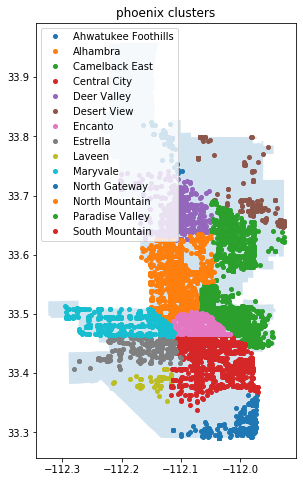

In [18]:
fig, ax = plt.subplots(figsize=(10,8))

phx_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx_points.groupby('name'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('phoenix clusters')
plt.legend()
plt.show()


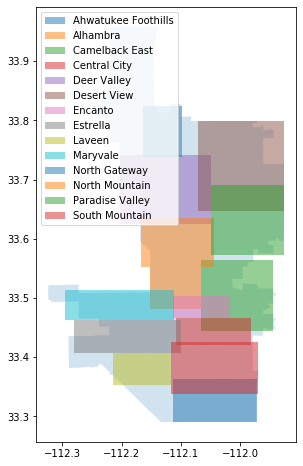

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

phx_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx_points.groupby('name'):
    if (group['lon'].max()-group['lon'].min() < 0.2) & (group['lat'].max()-group['lat'].min() < 0.2):
        points_x = [group['lon'].min(), group['lon'].min(), group['lon'].max(), group['lon'].max()]
        points_y = [group['lat'].min(), group['lat'].max(), group['lat'].max(), group['lat'].min()]
        ax.fill(points_x, points_y,label=name,alpha=0.5)
plt.legend()

plt.show()


In [20]:
tor = df_biz.loc[df_biz['city']=='Toronto'].copy()
craycray_clust(tor,tsne_perplexity=50,dbscan_eps=5)

In [21]:
# https://open.toronto.ca/dataset/neighbourhoods/
tor_map = gpd.read_file('toronto_wards.geojson')
# url = "https://gist.githubusercontent.com/jasonicarter/639c7f839c9c6e8c02a8eea9ac4bd1b0/raw/d6de8b89bfe38b0a2b0105f60038688259106a35/toronto_topo.json"
# tor_map = gpd.read_file(url)
tor_map['colors']=range(tor_map.shape[0])
tor_map['coords'] = tor_map['geometry'].apply(lambda x: x.representative_point().coords[:])
tor_map['coords'] = [coords[0] for coords in tor_map['coords']]
tor_map['name']=tor_map['AREA_NAME']
# tor_map['name']=tor_map['name'].apply(lambda x: x.replace(' ','\n').replace('-','\n').replace('/','/\n').split('(')[0])

In [22]:
# https://gis.stackexchange.com/questions/282681/filter-a-geopandas-dataframe-for-points-within-a-specific-country
# https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
tor_points = gpd.GeoDataFrame(tor,geometry = gpd.points_from_xy(tor['lon'],tor['lat']))
tor_points = sjoin(tor_points, tor_map, how='left')

/opt/anaconda3/envs/cities/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


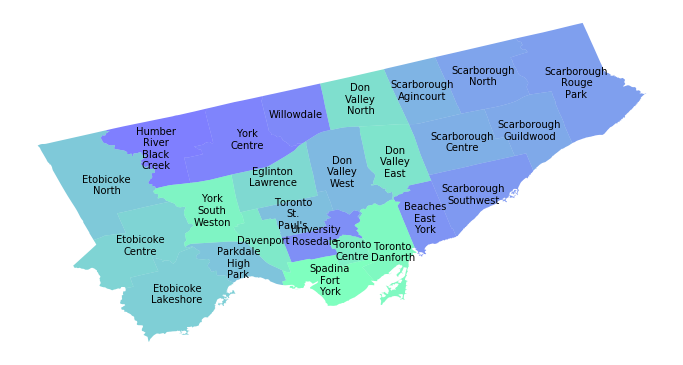

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
tor_map.plot(ax=ax,alpha=0.5,cmap='winter')

for idx, row in tor_map.iterrows():
    ax.annotate(s=row['name'].replace(' ','\n').replace('-','\n'), xy=row['coords'], fontsize=10,
                 horizontalalignment='center',verticalalignment='center')
ax.axis('off')
plt.savefig("toronto.svg", format="svg")


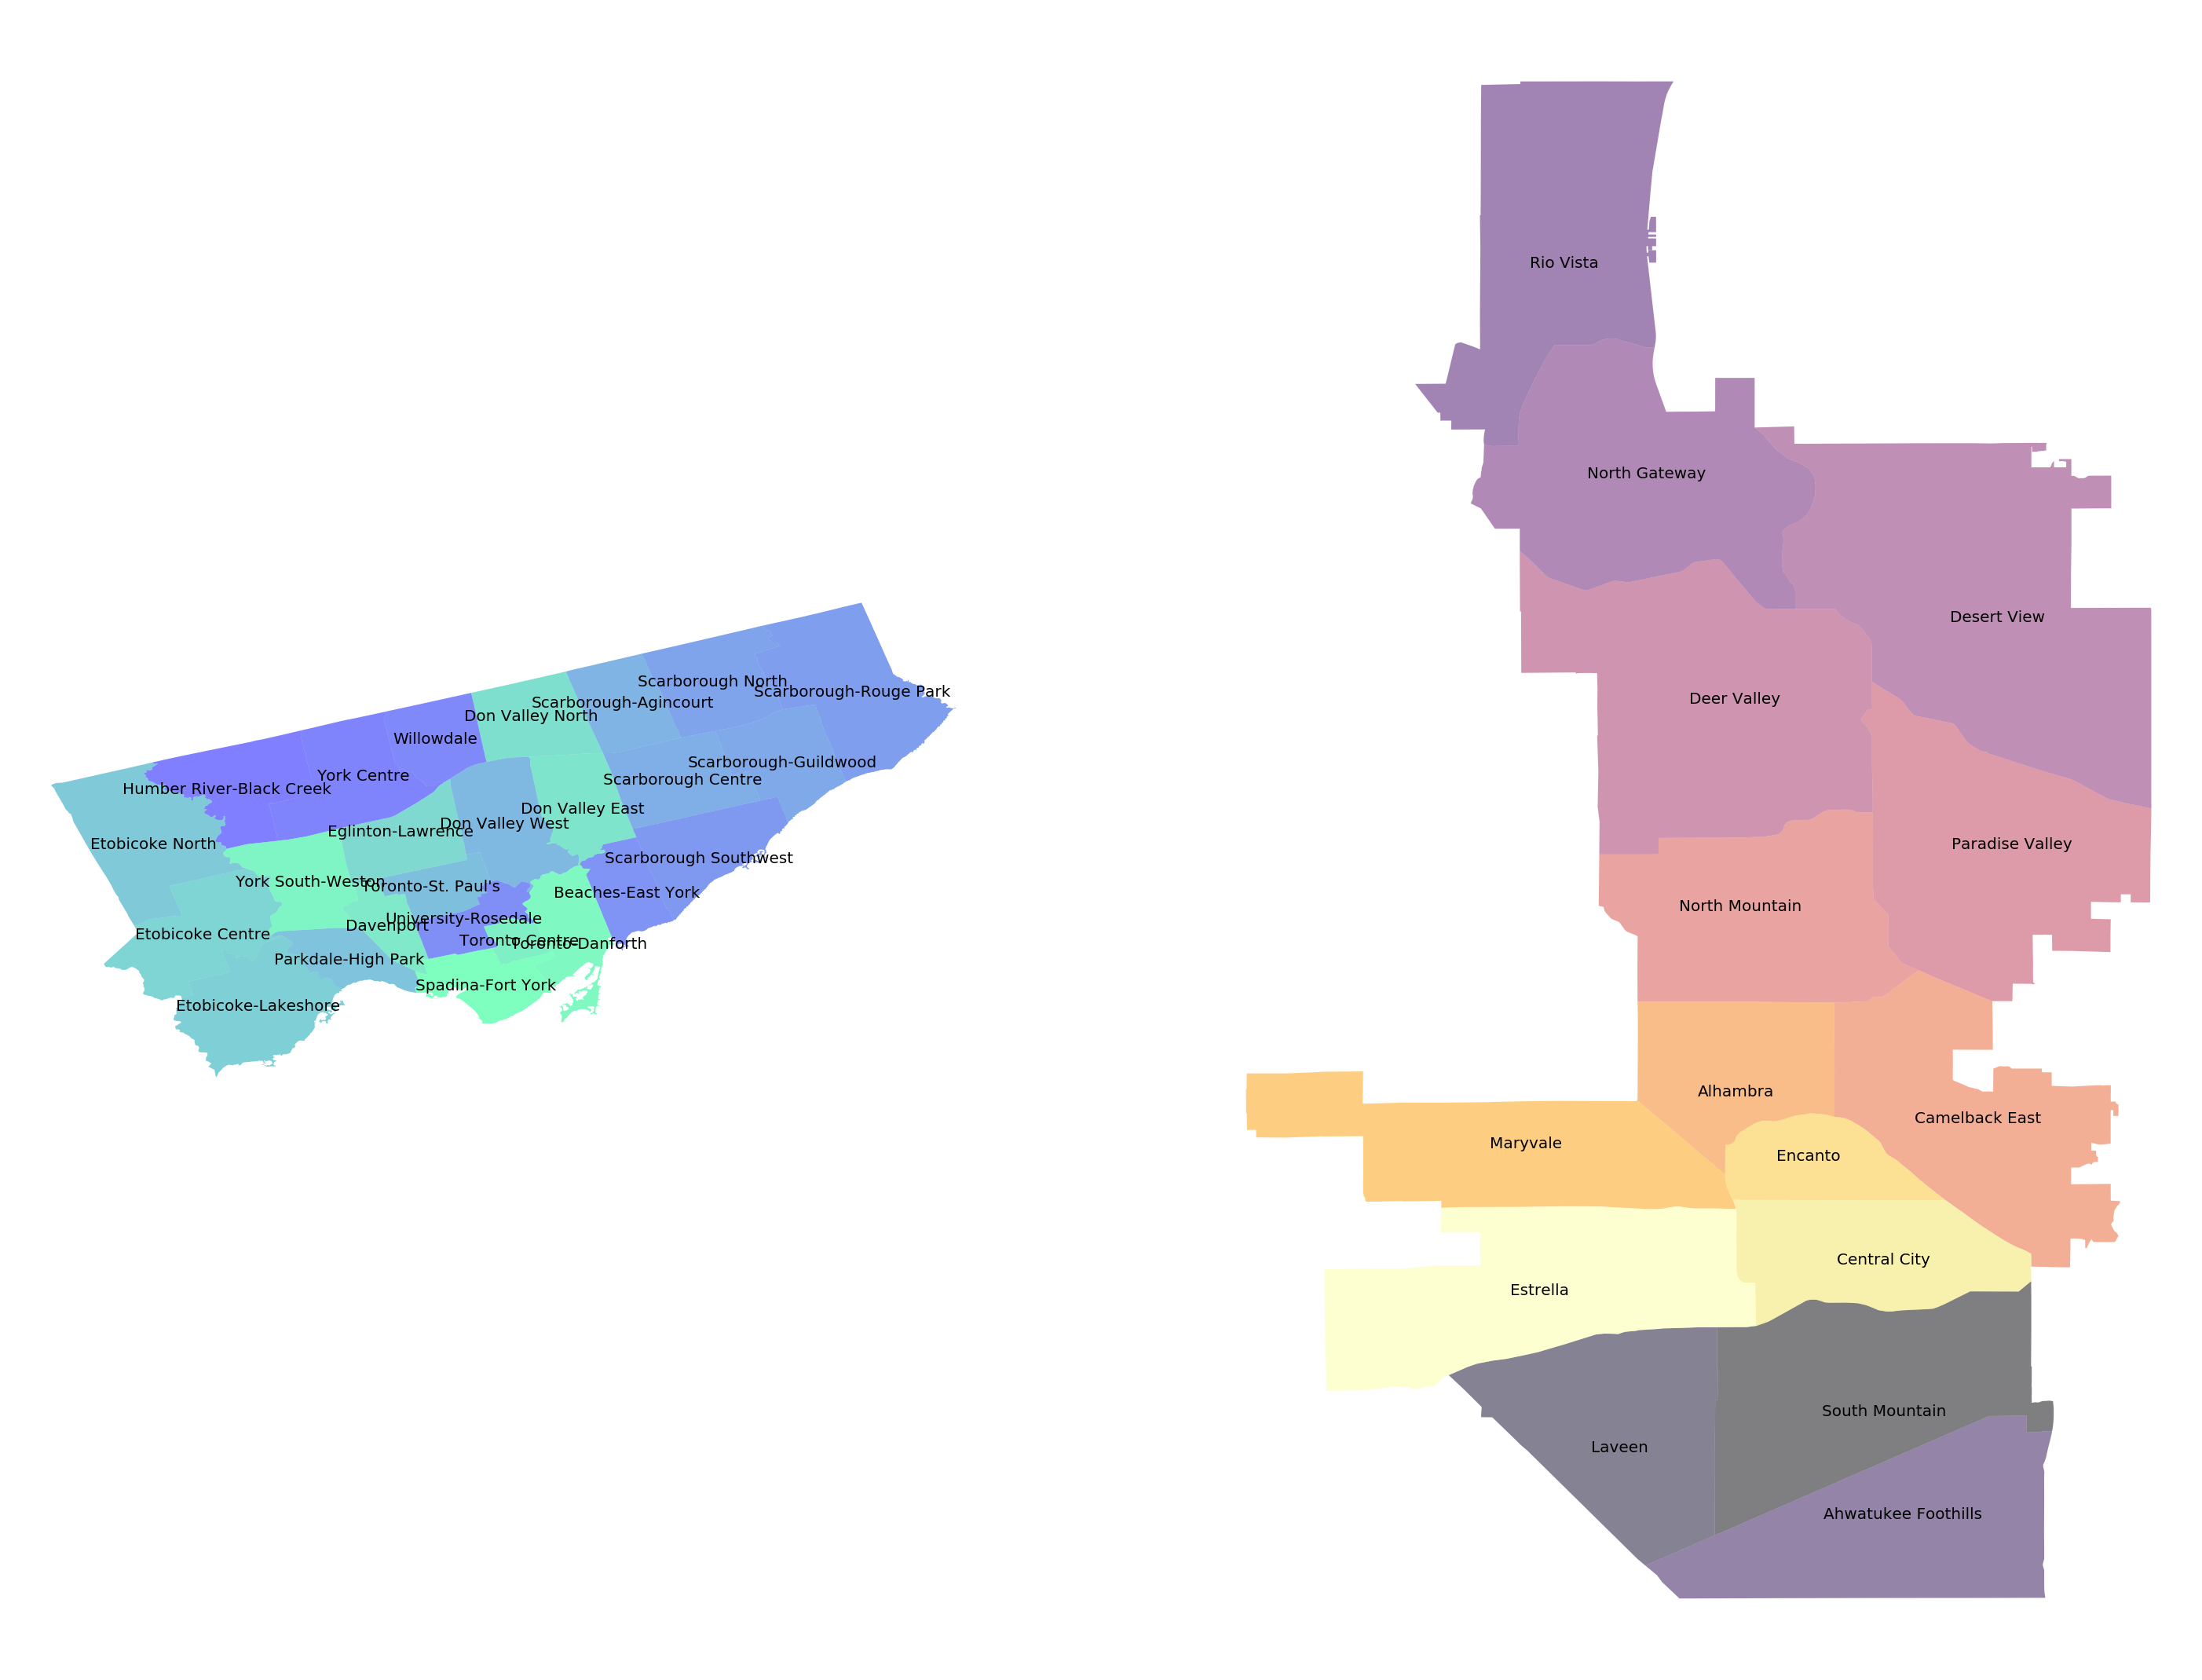

In [23]:
fig, axs = plt.subplots(1,2,figsize=(50,50))
ax=axs[0]
tor_map.plot(ax=ax,alpha=0.5,cmap='winter')

for idx, row in tor_map.iterrows():
    ax.annotate(s=row['name'], xy=row['coords'], fontsize=20,
                 horizontalalignment='center',verticalalignment='center')
ax.axis('off')

ax=axs[1]
phx_map.plot(ax=ax,alpha=0.5,cmap='inferno')

for idx, row in phx_map.iterrows():
    ax.annotate(s=row['name'], xy=row['coords'], fontsize=20,
                 horizontalalignment='center',verticalalignment='center')
ax.axis('off')

fig.patch.set_visible(False)
plt.savefig("maps.svg", format="svg")
plt.show()

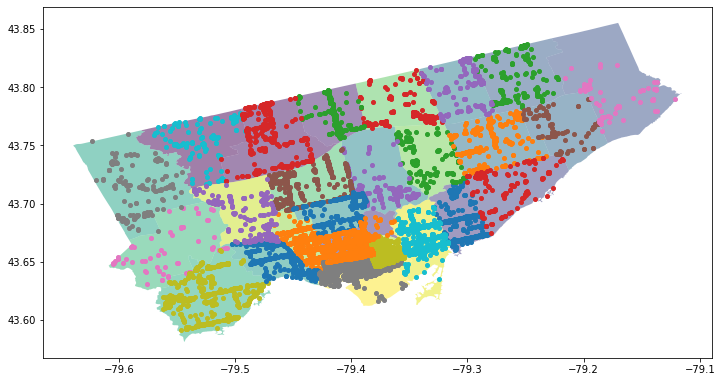

In [24]:
fig, ax = plt.subplots(figsize=(12,10))

tor_map.plot(ax=ax,alpha=0.5,cmap='viridis')

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor_points.groupby('name'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)

plt.show()

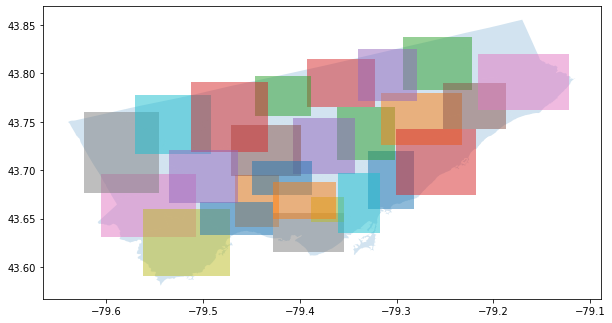

In [25]:
fig, ax = plt.subplots(figsize=(10,8))

tor_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor_points.groupby('name'):
    points_x = [group['lon'].min(), group['lon'].min(), group['lon'].max(), group['lon'].max()]
    points_y = [group['lat'].min(), group['lat'].max(), group['lat'].max(), group['lat'].min()]
    ax.fill(points_x, points_y,label=name,alpha=0.5)

plt.show()


In [26]:
# S = cosine_similarity(cats.values)

In [27]:
cat_arr = cats.values

In [28]:
t_clusts = []
p_clusts = []
sims = []
for name_t, group_t in tor_points.groupby('name'):
    for name_p, group_p in phx_points.groupby('name'):
        cat_t = cat_arr[group_t['ind'],:].sum(axis=0,keepdims=True)
        cat_p = cat_arr[group_p['ind'],:].sum(axis=0,keepdims=True)
        sim = cosine_similarity(cat_t,cat_p)
#         sim = S[np.ix_(group_t['ind'],group_p['ind'])].mean()
        t_clusts.append(name_t)
        p_clusts.append(name_p)
        sims.append(sim[0][0])
df_cl = pd.DataFrame(list(zip(t_clusts,p_clusts,sims)),columns=['t_clust','p_clust','sim']) 

In [29]:
# df_cl_t = tor_points.groupby('name')['lat','lon'].mean().copy().reset_index()
# df_cl_t['x']=df_cl_t['lon']
# df_cl_t['y']=df_cl_t['lat']

t_i_clusts = []
t_i_x = []
t_i_y = []

for name_i, group_i in tor_map.groupby('name'):
    i_coords = np.array([group_i['coords'].values[0]])
    t_i_clusts.append(name_i)
    t_i_x.append(i_coords[0][0])
    t_i_y.append(i_coords[0][1])

df_cl_t = pd.DataFrame(list(zip(t_i_clusts,t_i_x,t_i_y)),
                       columns=['name','x','y']) 


In [30]:
p_i_clusts = []
p_j_clusts = []
p_i_x = []
p_i_y = []
p_dists = []

# for name_i, group_i in phx_points.groupby('name'):
#     for name_j, group_j in phx_points.groupby('name'):
#         np.array([np.array(a) for a in group_i['coords'].values])
#         dist = cdist(group_i['coords'].values,group_j['coords'].values).mean()
#         p_i_clusts.append(name_i)
#         p_j_clusts.append(name_j)
#         p_i_x.append(group_i['lon'].mean())
#         p_i_y.append(group_i['lat'].mean())
#         p_dists.append(dist)

for name_i, group_i in phx_map.groupby('name'):
    for name_j, group_j in phx_map.groupby('name'):
        i_coords = np.array([group_i['coords'].values[0]])
        j_coords = np.array([group_j['coords'].values[0]])
        dist = cdist(i_coords,j_coords)[0][0]
        p_i_clusts.append(name_i)
        p_j_clusts.append(name_j)
        p_i_x.append(i_coords[0][0])
        p_i_y.append(i_coords[0][1])
        p_dists.append(dist)

df_cl_p = pd.DataFrame(list(zip(p_i_clusts,p_j_clusts,p_dists,p_i_x,p_i_y)),
                       columns=['p_i_clust','p_j_clust','dist','x','y']) 


In [31]:
df_cl_t['source'] = df_cl_t['name'].apply(str)
df_cl['source'] = df_cl['p_clust'].apply(str)
df_cl['target'] = df_cl['t_clust'].apply(str)
df_cl_p['source'] = df_cl_p['p_i_clust'].apply(str)
df_cl_p['target'] = df_cl_p['p_j_clust'].apply(str)

df_cl['type'] = 1
df_cl_t['type'] = 0
df_cl_p['type'] = 0

df_cl['mobile'] = 0
df_cl_t['mobile'] = 0
df_cl_p['mobile'] = 1




length_scale = tor_map.bounds['maxy'].max()-tor_map.bounds['miny'].min()
df_cl_t['x'] = (df_cl_t['x']-tor_map.bounds['minx'].min())/length_scale
df_cl_t['y'] = (df_cl_t['y']-tor_map.bounds['miny'].min())/length_scale

length_scale = phx_map.bounds['maxy'].max()-phx_map.bounds['miny'].min()
df_cl_p['x'] = (df_cl_p['x']-phx_map.bounds['minx'].min())/length_scale
df_cl_p['y'] = (df_cl_p['y']-phx_map.bounds['miny'].min())/length_scale


df_cl_p['dist'] = df_cl_p['dist']/length_scale


In [32]:
df_cl_combo = pd.concat([df_cl_t,df_cl_p],axis=0,sort=False)
df_cl_combo = df_cl_combo.fillna(-1)

unique_ips = df_cl_combo[['source','x','y','mobile']].drop_duplicates().set_index('source')

df_cl_combo = pd.concat([df_cl,df_cl_p],axis=0,sort=False)
df_cl_combo = df_cl_combo.fillna(-1)

links_list = list(df_cl_combo.apply(lambda row: {"source": unique_ips.index.get_loc(row['source']), 
                                                      "target": unique_ips.index.get_loc(row['target']), 
                                                      "dist": row['dist'], 
                                                      "sim": row['sim'], 
                                                      "type": row['type'], 
                                                      "mobile": row['mobile']}, axis=1))
print('links made')
nodes_list = []
for ip in unique_ips.index:
    nodes_list.append({"name":ip, 
                       "group": unique_ips.index.get_loc(ip), 
                       "xo": unique_ips.loc[ip,'x'],
                       "yo": unique_ips.loc[ip,'y'],
                       "mobile": float(unique_ips.loc[ip,'mobile']),
                      })
print('nodes made')
json_prep = {"nodes":nodes_list, "links":links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

with open('city_export.json','w') as f:
    f.write(json_dump)
    
#https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.PolynomialTransform

links made
nodes made
